In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

SCRIPT_DIR_PATHLIB = Path().parent

ROSBAG_NAME = "sample.bag"
ROSBAG_PATH = str(SCRIPT_DIR_PATHLIB.joinpath("data", ROSBAG_NAME))
N_READ_FRAME = 10

COLOR_IMAGE_TOPIC = "/device_0/sensor_1/Color_0/image/data"
DEPTH_IMAGE_TOPIC = "/device_0/sensor_0/Depth_0/image/data"


In [3]:
from enum import IntEnum

class FrameType(IntEnum):
    ColorFrame = 0
    DepthFrame = 1

In [4]:
def classify_frame_type(topic: str) -> FrameType:
    if topic == COLOR_IMAGE_TOPIC:
        return FrameType.ColorFrame
    elif topic == DEPTH_IMAGE_TOPIC:
        return FrameType.DepthFrame
    else:
        raise NotImplementedError()

# Load RGB-D images

In [5]:
import numpy as np
from rosbags.typesys.types import sensor_msgs__msg__Image as ROSImageMsg


def msg2ndarray(image_msg: ROSImageMsg):
    image_width = image_msg.width
    image_height = image_msg.height
    if image_msg.encoding == "rgb8":
        image_ndarray = np.zeros((image_height, image_width, 3), dtype=np.uint8)
        image_ndarray[:] = image_msg.data.reshape(image_height, image_width, 3).astype(np.uint8)
        return image_ndarray
    elif image_msg.encoding == "mono16":
        image_ndarray = np.zeros((image_height, image_width), dtype=np.int16)
        image_ndarray[:] = np.frombuffer(image_msg.data.tobytes(), dtype=np.int16).reshape(image_height, image_width)
        return image_ndarray
    else:
        raise NotImplementedError()


In [6]:
from rosbags.rosbag1 import Reader
from rosbags.serde import deserialize_ros1, deserialize_cdr, ros1_to_cdr

msgtype_list = []
color_image_list = []
depth_image_list = []
frame_count_color = 0
frame_count_depth = 0
with Reader(ROSBAG_PATH) as reader:
    for connection in reader.connections:
        if connection.msgtype == "sensor_msgs/msg/Image":
            print(connection.topic, connection.msgtype)

    for connection, timestamp, rawdata in reader.messages():
        if connection.topic in [COLOR_IMAGE_TOPIC, DEPTH_IMAGE_TOPIC]:
            # https://gitlab.com/ternaris/rosbags/-/issues/37
            image_msg = deserialize_cdr(ros1_to_cdr(rawdata[:-4], connection.msgtype), connection.msgtype)
            frame_type: FrameType = classify_frame_type(connection.topic)
            if frame_type == FrameType.ColorFrame:
                color_image_list.append(msg2ndarray(image_msg))
                frame_count_color += 1
            elif frame_type == FrameType.DepthFrame:
                depth_image_list.append(msg2ndarray(image_msg))
                frame_count_depth += 1
            if (frame_count_color >= N_READ_FRAME) and (frame_count_depth >= N_READ_FRAME):
                break


/device_0/sensor_1/Color_0/image/data sensor_msgs/msg/Image
/device_0/sensor_0/Depth_0/image/data sensor_msgs/msg/Image


# Visualize RGB-D images

In [7]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def bgr2rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def cv2pil(image_array: np.ndarray) -> Image:
    image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    return Image.fromarray(image_array)


def show_image_from_ndarray(image_array):
    if (len(image_array.shape) < 3) or (image_array.shape[-1] == 1):
        plt.imshow(image_array)
        plt.axis("off")
    else:
        plt.imshow(cv2pil(image_array))
        plt.axis("off")


def draw_multiple_image(titles, images):
    n_images = len(images)
    assert len(titles) == n_images

    fig, axes = plt.subplots(1, n_images)
    for i in range(n_images):
        axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axes[i].set_title(titles[i])
        axes[i].axis("off")


def colorize_depth_image(img, max_var=5000):
    """
    Convert 16bit single-channel depth image to color scaled image
    """
    img_colorized = np.zeros([img.shape[0], img.shape[1], 3]).astype(np.uint8)
    img_colorized[:, :, 1] = 255
    img_colorized[:, :, 2] = 255

    img_hue = img.copy().astype(np.float32)
    img_hue[np.where(img_hue > max_var)] = 0
    zero_idx = np.where((img_hue > max_var) | (img_hue == 0))
    img_hue *= 255.0 / max_var

    img_colorized = cv2.applyColorMap(img_hue.astype(np.uint8), cv2.COLORMAP_JET)
    img_colorized[zero_idx[0], zero_idx[1], :] = 0
    return img_colorized

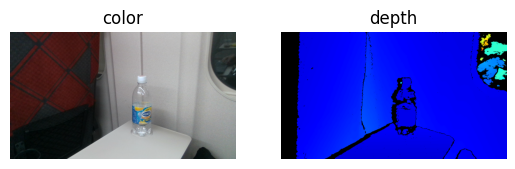

In [8]:
color_image = color_image_list[0]
depth_image = depth_image_list[1]
draw_multiple_image(["color", "depth"], [bgr2rgb(color_image), colorize_depth_image(depth_image)])